# Определение стоимости автомобилей

Описание задания:
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Целевая метрика для качества регрессии RMSE < 2500

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, metrics, cv
import lightgbm as lgb
from lightgbm import LGBMRegressor
import time
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.model_selection import cross_validate

## Подготовка данных

In [2]:
try:
    df = pd.read_csv('autos.csv')
except FileNotFoundError as e:
    print(repr(e))
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Приведем DateCrawled к формату datetime

In [5]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])

In [6]:
df['DateCrawled_Y'] = df['DateCrawled'].dt.strftime('%Y')

In [7]:
df['DateCrawled_Y'].unique()

array(['2016'], dtype=object)

In [8]:
df['DateCrawled_m'] = df['DateCrawled'].dt.strftime('%m')

In [9]:
df['DateCrawled_m'].unique()

array(['03', '04'], dtype=object)

Все объявления относятся к периоду с 2016-03 по 2016-04. Эта информация далее нам не будет полезна в качестве признака

In [10]:
df.drop(['DateCrawled','DateCrawled_Y','DateCrawled_m'],axis=1,inplace=True)

In [11]:
df.head()

Price VehicleType  RegistrationYear Gearbox  Power  Model  Kilometer  \
0    480         NaN              1993  manual      0   golf     150000   
1  18300       coupe              2011  manual    190    NaN     125000   
2   9800         suv              2004    auto    163  grand     125000   
3   1500       small              2001  manual     75   golf     150000   
4   3600       small              2008  manual     69  fabia      90000   

   RegistrationMonth  FuelType       Brand NotRepaired          DateCreated  \
0                  0    petrol  volkswagen         NaN  2016-03-24 00:00:00   
1                  5  gasoline        audi         yes  2016-03-24 00:00:00   
2                  8  gasoline        jeep         NaN  2016-03-14 00:00:00   
3                  6    petrol  volkswagen          no  2016-03-17 00:00:00   
4                  7  gasoline       skoda          no  2016-03-31 00:00:00   

   NumberOfPictures  PostalCode             LastSeen  
0                 0       70435  2016-04-07 03:16:57  
1                 0       66954  2016-04-07 01:46:50  
2                 0       90480  2016-04-05 12:47:46  
3                 0       91074  2016-03-17 17:40:17  
4                 0       60437  2016-04-06 10:17:21

In [12]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.000000  
50%             6.000000               0.0   49413.000000  
75%             9.000000               0.0   71083.000000  
max            12.000000               0.0   99998.000000

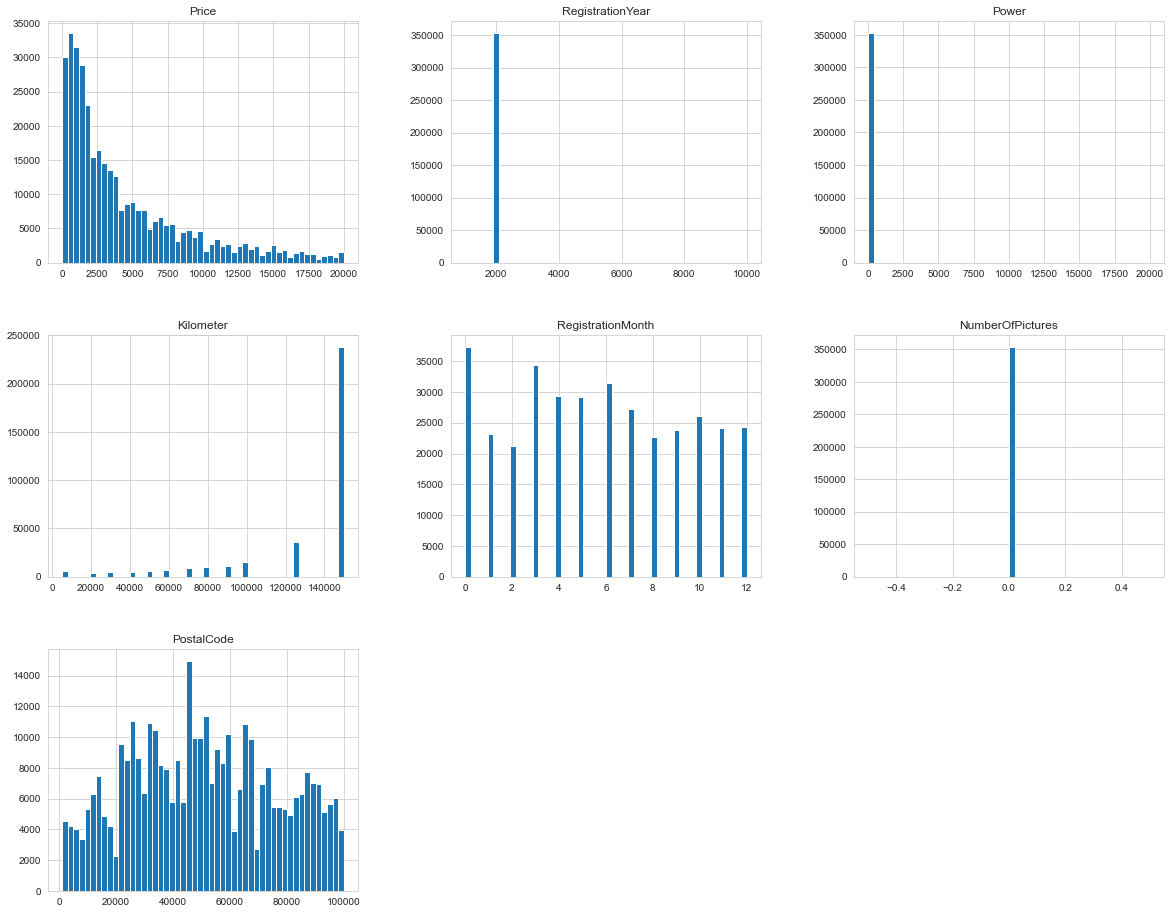

In [13]:
df.hist(figsize=(20,16), bins=50)
plt.show()

В данных имеются, выбросы, пропуски. Будем "чистить" данные, так как задача нашей модели предсказать рыночную стоимость автомобиля, соответственно если в обучающую выборку попадут неадекватные ошибочные данные то это никак не поможет нашей модели точнее предсказывать цену для объявлений c корректной информацией

Очевидно, что если неизвестна модель и марка автомобиля то не имеет никакого смысла предсказывать цену такому клиенту. Удалим данные записи из выборки

In [14]:
df.dropna(subset=['Brand', 'Model'], inplace=True)

In [15]:
df.isna().sum()

Price                    0
VehicleType          30662
RegistrationYear         0
Gearbox              15702
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType             25732
Brand                    0
NotRepaired          62100
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

На гистограмме столбца "Power" очевидно наличие выбросов и некорректных данных, разберемся подробнее:

In [16]:
df.sort_values(by='Power', ascending=False).head(20)

Price  VehicleType  RegistrationYear Gearbox  Power      Model  \
219584   4300        coupe              1999    auto  20000        clk   
299180   1500        wagon              1997  manual  19312        5er   
114106   9999        sedan              2006  manual  19211        1er   
132485   2100        wagon              2001  manual  19208        5er   
63986    3250        sedan              2001    auto  17932      omega   
196532   6000        wagon              2004    auto  17700        5er   
150676   1700        wagon              1995  manual  17410         80   
187330   1749        wagon              1989  manual  17019        3er   
175422  10900        sedan              2007    auto  17011         a3   
216993  11950  convertible              2008  manual  16312         a4   
311399  11900        wagon              2007    auto  16311        5er   
248569   5000          NaN              2018  manual  16011    octavia   
205808   3150        coupe              2007  manual  15033      other   
148466   3650        small              2002    auto  15020        147   
260799   1750        wagon              2003    auto  15017        3er   
85229       0          NaN              2016  manual  15016  ptcruiser   
162214   5200        small              2005  manual  15001     fiesta   
227634  15499        wagon              2012  manual  13636   c_klasse   
214169    500          NaN              2016  manual  13616   e_klasse   
292167   2000          bus              2003  manual  12512     zafira   

        Kilometer  RegistrationMonth  FuelType          Brand NotRepaired  \
219584     150000                  1    petrol  mercedes_benz          no   
299180     150000                  1       NaN            bmw          no   
114106     125000                  0  gasoline            bmw         NaN   
132485     150000                  5       NaN            bmw         yes   
63986      150000                  6    petrol           opel         NaN   
196532     150000                  7  gasoline            bmw          no   
150676       5000                  0    petrol           audi         yes   
187330       5000                 12    petrol            bmw         NaN   
175422       5000                  7  gasoline           audi         NaN   
216993      20000                  4    petrol           audi          no   
311399     150000                 10  gasoline            bmw          no   
248569     150000                  2    petrol          skoda         yes   
205808       5000                  3  gasoline     alfa_romeo          no   
148466     125000                 11    petrol     alfa_romeo          no   
260799     150000                 11  gasoline            bmw         NaN   
85229      150000                 12  gasoline       chrysler         NaN   
162214     150000                 12    petrol           ford          no   
227634     125000                  4  gasoline  mercedes_benz          no   
214169     150000                  8       NaN  mercedes_benz         NaN   
292167     150000                 12    petrol           opel         NaN   

                DateCreated  NumberOfPictures  PostalCode             LastSeen  
219584  2016-03-09 00:00:00                 0       19406  2016-03-30 08:47:08  
299180  2016-03-09 00:00:00                 0       21129  2016-04-07 11:44:34  
114106  2016-04-03 00:00:00                 0       45964  2016-04-07 10:16:10  
132485  2016-03-25 00:00:00                 0       59556  2016-03-30 05:16:18  
63986   2016-03-28 00:00:00                 0       86641  2016-04-06 14:17:21  
196532  2016-03-20 00:00:00                 0       26316  2016-04-06 22:45:56  
150676  2016-03-09 00:00:00                 0       23562  2016-03-15 07:17:06  
187330  2016-03-17 00:00:00                 0       89542  2016-03-26 00:46:59  
175422  2016-03-19 00:00:00                 0       12355  2016-03-21 15:20:06  
216993  2016-03-10 00:00:

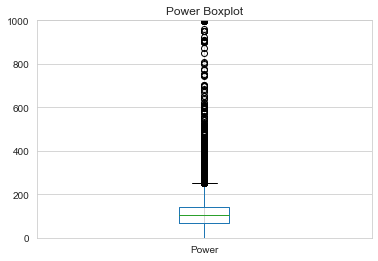

In [17]:
plt.title('Power Boxplot')
df.boxplot(column='Power')
plt.ylim((0,1000))
plt.show()


Да, значения мощности не во всех объявлениях указаны верно, но при этом ящик с усами отправляет в выбросы вполне реальные значения мощности до 600 лс, при этом также есть значения мощности вплоть до 0 л.c...

In [18]:
df.query('300<Power<600').sort_values(by='Power', ascending=False).head(50)

Price VehicleType  RegistrationYear Gearbox  Power     Model  \
182900      0       small              1999    auto    599     other   
14555     599         NaN              2018  manual    599    twingo   
138257  14750       sedan              2014    auto    585  e_klasse   
114478   4538       coupe              2015    auto    585  s_klasse   
152546    500       small              2005  manual    584     matiz   
107164    250       small              2001  manual    580    twingo   
233698      0       sedan              2015  manual    580     punto   
307452  18200       wagon              2008    auto    579     other   
105658  19000       wagon              2008    auto    579     other   
320566  14750       wagon              2008    auto    579     other   
209751      1         NaN              1995     NaN    574       3er   
243754  13500       sedan              1994  manual    572    vectra   
75230   17999       sedan              2012    auto    560   m_reihe   
311474  10500       coupe              1995  manual    551     other   
120559   9999       coupe              1999  manual    550      golf   
124348  19999       sedan              2005     NaN    550     other   
249174   5499       sedan              1989  manual    544      golf   
44485     499       small              1994  manual    541    twingo   
261601   9100       sedan              2003    auto    540  e_klasse   
168491      0         NaN              2005    auto    530     other   
156234  19500       coupe              2015  manual    525   mustang   
198740  18500         NaN              2017    auto    521   cayenne   
82421   13500         suv              2006    auto    521   cayenne   
344689  14900         suv              2006    auto    521   cayenne   
173074  11900         suv              2006    auto    521   cayenne   
20145   18500         suv              2006    auto    521   cayenne   
96747   13500         NaN              2006    auto    521   cayenne   
122594  13750       wagon              2006    auto    520        a6   
73749   18500       sedan              2012    auto    520     other   
138169  19900       coupe              2004    auto    519       clk   
94999   19490       sedan              2006    auto    517  s_klasse   
264192  19900       sedan              2007    auto    517  s_klasse   
21161     250       small              1995  manual    515      polo   
32693   16999       sedan              2006    auto    515        a8   
222381  17000       sedan              2006    auto    515        a8   
304064  14900       sedan              2007    auto    514  e_klasse   
208144  19999       coupe              2007    auto    514     other   
313123  15700       sedan              2009    auto    514  e_klasse   
162334  18900       sedan              2006    auto    514  e_klasse   
218406  14500       wagon              2004    auto    510     other   
158083  16000         suv              2006    auto    510  m_klasse   
155997  16500       wagon              2003    auto    510     other   
176792  18000         suv              2006    auto    510  m_klasse   
308872  16500       coupe              2000    auto    508        cl   
25684   20000       sedan              2006    auto    507   m_reihe   
260605  15000       sedan              2006    auto    507       5er   
241096   2500       coupe              2005    auto    507   m_reihe   
91326       0       sedan              2007    auto    507       5er   
288154      0       sedan              2006    auto    507       5er   
320093  15500       coupe              2009    auto    507   m_reihe   

        Kilometer  RegistrationMonth FuelType          Brand NotRepaired  \
182900     150000                  0   petrol          smart         NaN   
14555      150000                  0      NaN        renault         NaN   
138257     150000                  4   petrol  mercedes_benz          no   
114478       5000              

К сожалению и в этой категории есть ошибки, скажем Mercedes-Benz S-класса может иметь мощность 585 лс,  а вот Renault Twingo вряд ли.

Посмотрим какие бренды автомобилей имеются у нас в выборке

In [19]:
brands_list = list(df['Brand'].unique())
brands_list

['volkswagen',
 'jeep',
 'skoda',
 'bmw',
 'peugeot',
 'ford',
 'mazda',
 'nissan',
 'renault',
 'mercedes_benz',
 'opel',
 'seat',
 'citroen',
 'honda',
 'fiat',
 'mini',
 'smart',
 'hyundai',
 'audi',
 'alfa_romeo',
 'subaru',
 'volvo',
 'mitsubishi',
 'kia',
 'suzuki',
 'lancia',
 'toyota',
 'chevrolet',
 'dacia',
 'daihatsu',
 'chrysler',
 'jaguar',
 'daewoo',
 'porsche',
 'rover',
 'saab',
 'land_rover',
 'trabant',
 'lada']

In [20]:
brands_with_high_power = df[df['Power']>300]['Brand'].unique()
brands_with_high_power

array(['mercedes_benz', 'ford', 'bmw', 'opel', 'audi', 'porsche',
       'toyota', 'seat', 'volkswagen', 'mitsubishi', 'chevrolet', 'fiat',
       'lancia', 'nissan', 'volvo', 'mazda', 'chrysler', 'jaguar', 'jeep',
       'renault', 'citroen', 'skoda', 'peugeot', 'smart', 'kia', 'subaru',
       'hyundai', 'suzuki', 'land_rover', 'daihatsu', 'mini',
       'alfa_romeo', 'honda', 'daewoo', 'saab', 'dacia'], dtype=object)

Премиальные бренды

In [21]:
p_brands = ['audi',
            'bmw',
            'mercedes_benz',
            'jaguar',
            'porsche',
            'land_rover',
            ]

Исходя из здравого смысла оставим только те записи с мощностью 300-600лс марки которых относятся к премиум брендам (у них есть автомобили с такой мощностью)

In [22]:
df = df.query('Power<=300 or (300<Power<600 and Brand in @p_brands)')

Посмотрим аномалии в столбце "Power" по нижней границе:

Сформируем отдельную таблицу для машин с мощностью от 0 до 50 л.с.

In [23]:
low_power_cars = df.query('0<=Power<50').sort_values(by='Power', ascending=False)

Будет полезно также сформировать группы по поколениям:

In [24]:
year_bins = [0,1950,1970,1980,1990,2000,2010,2020,2030]

In [25]:
year_bins_names = ['<50','50-70','70-80','80-90','90-00','00-10','10-20','20+']

In [26]:
low_power_cars['Year_bin'] = (pd.cut(low_power_cars['RegistrationYear'],year_bins, labels=year_bins_names))

In [27]:
low_power_cars[['Year_bin','RegistrationYear']].head()

Year_bin  RegistrationYear
240914    90-00              1993
239900    90-00              1999
327735    00-10              2008
303685    80-90              1988
181761    00-10              2001

In [28]:
low_power_cars['Year_bin'] = low_power_cars['Year_bin'].astype(str)

Сформируем столбец объединяющий марку модель и поколение

In [29]:
low_power_cars['model_brand'] = low_power_cars['Brand'] +'_'+ low_power_cars['Model'] +'_' + \
                                low_power_cars['Year_bin']

In [30]:
low_power_cars['model_brand']

240914    volkswagen_transporter_90-00
239900                   ford_ka_90-00
327735              hyundai_getz_00-10
303685               ford_fiesta_80-90
181761                opel_corsa_00-10
                      ...             
125709           peugeot_3_reihe_00-10
125695             citroen_other_00-10
125670                   ford_ka_00-10
125664              smart_fortwo_00-10
354364           mitsubishi_colt_00-10
Name: model_brand, Length: 39229, dtype: object

Сгруппируем данные по новому столбцу (модель_год_поколение) и найдем медиану мощности для каждого значения

In [31]:
low_power_cars_gr = low_power_cars.groupby('model_brand')['Power'].median()
low_power_cars_gr

model_brand
alfa_romeo_145_00-10    0.0
alfa_romeo_145_10-20    0.0
alfa_romeo_145_50-70    0.0
alfa_romeo_145_80-90    0.0
alfa_romeo_145_90-00    0.0
                       ... 
volvo_v70_00-10         0.0
volvo_v70_10-20         0.0
volvo_v70_90-00         0.0
volvo_xc_reihe_00-10    0.0
volvo_xc_reihe_10-20    0.0
Name: Power, Length: 1058, dtype: float64

Проделаем те же операции для оригинальной таблицы:

In [32]:
df['Year_bin'] = (pd.cut(df['RegistrationYear'],year_bins, labels=year_bins_names))

In [33]:
df['Year_bin'] = df['Year_bin'].astype(str)

In [34]:
df['model_brand'] = df['Brand'] +'_'+ df['Model'] +'_' + \
                                df['Year_bin']

In [35]:
all_power_cars_gr = df.query('Power>=50').groupby('model_brand')['Power'].median()

Сравним медианы "маломощных" моделей из подвыборки 0<Power<50 и оригинальной таблицы

In [36]:
compare_power = pd.merge(low_power_cars_gr, all_power_cars_gr, how='inner', on='model_brand')

In [37]:
compare_power

Power_x  Power_y
model_brand                           
alfa_romeo_145_00-10      0.0    111.5
alfa_romeo_145_10-20      0.0    103.0
alfa_romeo_145_90-00      0.0    103.0
alfa_romeo_147_00-10      0.0    120.0
alfa_romeo_147_10-20      0.0    120.0
...                       ...      ...
volvo_v70_00-10           0.0    163.0
volvo_v70_10-20           0.0    151.5
volvo_v70_90-00           0.0    144.0
volvo_xc_reihe_00-10      0.0    185.0
volvo_xc_reihe_10-20      0.0    163.0

[917 rows x 2 columns]

In [38]:
compare_power.sort_values(by='Power_y')

Power_x  Power_y
model_brand                              
volkswagen_kaefer_80-90     34.0     50.0
volkswagen_caddy_70-80       0.0     50.0
volkswagen_kaefer_70-80     34.0     50.0
volkswagen_kaefer_10-20     34.0     50.0
mazda_1_reihe_10-20          0.0     50.0
...                          ...      ...
porsche_cayenne_00-10        0.0    340.0
porsche_cayenne_10-20        0.0    340.0
bmw_m_reihe_00-10            0.0    343.0
porsche_911_10-20            0.0    351.0
bmw_m_reihe_10-20            0.0    465.5

[917 rows x 2 columns]

Заменим значения мощности для моделей из "маломощной" подвыборки значением медианы для тех же моделей из всей таблицы

In [39]:
low_power_cars = low_power_cars.set_index('model_brand')

In [40]:
low_power_cars

Price  VehicleType  RegistrationYear Gearbox  \
model_brand                                                                  
volkswagen_transporter_90-00   1600          bus              1993  manual   
ford_ka_90-00                   160        small              1999  manual   
hyundai_getz_00-10             2450        small              2008  manual   
ford_fiesta_80-90               690        small              1988  manual   
opel_corsa_00-10               1000        small              2001  manual   
...                             ...          ...               ...     ...   
peugeot_3_reihe_00-10          4700  convertible              2005     NaN   
citroen_other_00-10               0        small              2001  manual   
ford_ka_00-10                   450        small              2002     NaN   
smart_fortwo_00-10             1499  convertible              2002     NaN   
mitsubishi_colt_00-10             0          NaN              2005  manual   

                              Power        Model  Kilometer  \
model_brand                                                   
volkswagen_transporter_90-00     49  transporter      90000   
ford_ka_90-00                    49           ka     150000   
hyundai_getz_00-10               49         getz     100000   
ford_fiesta_80-90                49       fiesta      80000   
opel_corsa_00-10                 49        corsa     150000   
...                             ...          ...        ...   
peugeot_3_reihe_00-10             0      3_reihe     150000   
citroen_other_00-10               0        other       5000   
ford_ka_00-10                     0           ka     150000   
smart_fortwo_00-10                0       fortwo     125000   
mitsubishi_colt_00-10             0         colt     150000   

                              RegistrationMonth  FuelType       Brand  \
model_brand                                                             
volkswagen_transporter_90-00                  4  gasoline  volkswagen   
ford_ka_90-00                                10    petrol        ford   
hyundai_getz_00-10                            4    petrol     hyundai   
ford_fiesta_80-90                             7    petrol        ford   
opel_corsa_00-10                              2    petrol        opel   
...                                         ...       ...         ...   
peugeot_3_reihe_00-10                         5    petrol     peugeot   
citroen_other_00-10                           0  gasoline     citroen   
ford_ka_00-10                                11    petrol        ford   
smart_fortwo_00-10                            7       NaN       smart   
mitsubishi_colt_00-10                         7    petrol  mitsubishi   

                             NotRepaired          DateCreated  \
model_brand                                                     
volkswagen_transporter_90-00          no  2016-03-09 00:00:00   
ford_ka_90-00                         no  2016-03-29 00:00:00   
hyundai_getz_00-10                    no  2016-04-02 00:00:00   
ford_fiesta_80-90                     no  2016-03-20 00:00:00   
opel_corsa_00-10                     NaN  2016-03-24 00:00:00   
...                                  ...                  ...   
peugeot_3_reihe_00-10                 no  2016-03-12 00:00:00   
citroen_other_00-10                  NaN  2016-03-14 00:00:00   
ford_ka_00-10                        NaN  2016-03-17 00:00:00   
smart_fortwo_00-10                    no  2016-04-02 00:00:00   
mitsubishi_colt_00-10                yes  2016-03-21 00:00:00   

                              NumberOfPictures  PostalCode  \
model_brand                                                  
volkswagen_transporter_90-00                 0       26129   
ford_ka_90-00                                0       44319   
hyundai_getz_00-10                           0       24116   
ford_fiesta_80-90                            0       53227   
opel_corsa_00-10           

In [41]:
low_power_cars = pd.merge(low_power_cars,compare_power['Power_y'],how='left',left_index=True, right_index=True)

In [42]:
low_power_cars

Price VehicleType  RegistrationYear Gearbox  Power  \
model_brand                                                                
alfa_romeo_145_00-10      0       sedan              2002     NaN      0   
alfa_romeo_145_10-20    999         NaN              2018     NaN      0   
alfa_romeo_145_10-20   1250         NaN              2017     NaN      0   
alfa_romeo_145_50-70    200         NaN              1960     NaN      0   
alfa_romeo_145_80-90    100         NaN              1990     NaN      0   
...                     ...         ...               ...     ...    ...   
volvo_xc_reihe_00-10   8200         suv              2006  manual      0   
volvo_xc_reihe_00-10   9800         suv              2005     NaN      0   
volvo_xc_reihe_10-20   9999         NaN              2017     NaN      0   
volvo_xc_reihe_10-20  16499         suv              2012  manual      0   
volvo_xc_reihe_10-20      0         NaN              2012     NaN      0   

                         Model  Kilometer  RegistrationMonth  FuelType  \
model_brand                                                              
alfa_romeo_145_00-10       145     150000                  1  gasoline   
alfa_romeo_145_10-20       145     150000                  0    petrol   
alfa_romeo_145_10-20       145      20000                  0    petrol   
alfa_romeo_145_50-70       145       5000                  0       NaN   
alfa_romeo_145_80-90       145     100000                  0       NaN   
...                        ...        ...                ...       ...   
volvo_xc_reihe_00-10  xc_reihe     150000                  5  gasoline   
volvo_xc_reihe_00-10  xc_reihe     150000                  9  gasoline   
volvo_xc_reihe_10-20  xc_reihe     150000                  0  gasoline   
volvo_xc_reihe_10-20  xc_reihe     150000                  6  gasoline   
volvo_xc_reihe_10-20  xc_reihe      90000                  0       NaN   

                           Brand NotRepaired          DateCreated  \
model_brand                                                         
alfa_romeo_145_00-10  alfa_romeo         NaN  2016-03-08 00:00:00   
alfa_romeo_145_10-20  alfa_romeo         NaN  2016-03-28 00:00:00   
alfa_romeo_145_10-20  alfa_romeo          no  2016-03-27 00:00:00   
alfa_romeo_145_50-70  alfa_romeo         NaN  2016-03-29 00:00:00   
alfa_romeo_145_80-90  alfa_romeo         NaN  2016-03-28 00:00:00   
...                          ...         ...                  ...   
volvo_xc_reihe_00-10       volvo         yes  2016-03-15 00:00:00   
volvo_xc_reihe_00-10       volvo          no  2016-03-19 00:00:00   
volvo_xc_reihe_10-20       volvo         NaN  2016-03-07 00:00:00   
volvo_xc_reihe_10-20       volvo         NaN  2016-03-17 00:00:00   
volvo_xc_reihe_10-20       volvo         NaN  2016-03-10 00:00:00   

                      NumberOfPictures  PostalCode             LastSeen  \
model_brand                                                               
alfa_romeo_145_00-10                 0       52062  2016-03-24 01:17:31   
alfa_romeo_145_10-20                 0       97509  2016-04-07 01:15:55   
alfa_romeo_145_10-20                 0       48455  2016-04-05 15:46:47   
alfa_romeo_145_50-70                 0       24960  2016-03-29 11:39:37   
alfa_romeo_145_80-90                 0       72070  2016-03-28 11:54:54   
...                                ...         ...                  ...   
volvo_xc_reihe_00-10                 0       63069  2016-03-15 14:47:46   
volvo_xc_reihe_00-10                 0       55124  2016-04-06 08:45:41   
volvo_xc_reihe_10-20                 0       60435  2016-03-17 19:46:53   
volvo_xc_reihe_10-20                 0       65197  2016-03-31 06:15:36   
volvo_xc_reihe_10-20                 0       78727  2016-03-11 04:17:26   

                     Year_bin  Power_y  
model_brand                             
alfa_romeo_145_00-10    00-10    111.5  
alfa_romeo_145_10-20    10-20    103.0  
alfa_romeo_145_10-20    10-20   

In [43]:
low_power_cars['Power'] = low_power_cars.apply(lambda x: max(x['Power'],x['Power_y']),axis=1)

In [44]:
low_power_cars.head()

Price VehicleType  RegistrationYear Gearbox  Power  \
model_brand                                                                
alfa_romeo_145_00-10      0       sedan              2002     NaN  111.5   
alfa_romeo_145_10-20    999         NaN              2018     NaN  103.0   
alfa_romeo_145_10-20   1250         NaN              2017     NaN  103.0   
alfa_romeo_145_50-70    200         NaN              1960     NaN    0.0   
alfa_romeo_145_80-90    100         NaN              1990     NaN    0.0   

                     Model  Kilometer  RegistrationMonth  FuelType  \
model_brand                                                          
alfa_romeo_145_00-10   145     150000                  1  gasoline   
alfa_romeo_145_10-20   145     150000                  0    petrol   
alfa_romeo_145_10-20   145      20000                  0    petrol   
alfa_romeo_145_50-70   145       5000                  0       NaN   
alfa_romeo_145_80-90   145     100000                  0       NaN   

                           Brand NotRepaired          DateCreated  \
model_brand                                                         
alfa_romeo_145_00-10  alfa_romeo         NaN  2016-03-08 00:00:00   
alfa_romeo_145_10-20  alfa_romeo         NaN  2016-03-28 00:00:00   
alfa_romeo_145_10-20  alfa_romeo          no  2016-03-27 00:00:00   
alfa_romeo_145_50-70  alfa_romeo         NaN  2016-03-29 00:00:00   
alfa_romeo_145_80-90  alfa_romeo         NaN  2016-03-28 00:00:00   

                      NumberOfPictures  PostalCode             LastSeen  \
model_brand                                                               
alfa_romeo_145_00-10                 0       52062  2016-03-24 01:17:31   
alfa_romeo_145_10-20                 0       97509  2016-04-07 01:15:55   
alfa_romeo_145_10-20                 0       48455  2016-04-05 15:46:47   
alfa_romeo_145_50-70                 0       24960  2016-03-29 11:39:37   
alfa_romeo_145_80-90                 0       72070  2016-03-28 11:54:54   

                     Year_bin  Power_y  
model_brand                             
alfa_romeo_145_00-10    00-10    111.5  
alfa_romeo_145_10-20    10-20    103.0  
alfa_romeo_145_10-20    10-20    103.0  
alfa_romeo_145_50-70    50-70      NaN  
alfa_romeo_145_80-90    80-90      NaN

Проверим корректность замены значений на примере одной модели

In [45]:
low_power_cars[low_power_cars.index == 'alfa_romeo_other_10-20']

Price VehicleType  RegistrationYear Gearbox  Power  \
model_brand                                                                  
alfa_romeo_other_10-20   6900       small              2011  manual  120.0   
alfa_romeo_other_10-20   9900         NaN              2017  manual  120.0   
alfa_romeo_other_10-20    500         NaN              2016  manual  120.0   

                        Model  Kilometer  RegistrationMonth  FuelType  \
model_brand                                                             
alfa_romeo_other_10-20  other      50000                 12  gasoline   
alfa_romeo_other_10-20  other      90000                 11    petrol   
alfa_romeo_other_10-20  other     150000                  0    petrol   

                             Brand NotRepaired          DateCreated  \
model_brand                                                           
alfa_romeo_other_10-20  alfa_romeo          no  2016-03-31 00:00:00   
alfa_romeo_other_10-20  alfa_romeo         NaN  2016-03-11 00:00:00   
alfa_romeo_other_10-20  alfa_romeo         yes  2016-03-15 00:00:00   

                        NumberOfPictures  PostalCode             LastSeen  \
model_brand                                                                 
alfa_romeo_other_10-20                 0       66111  2016-04-04 09:17:02   
alfa_romeo_other_10-20                 0       74078  2016-03-26 13:45:23   
alfa_romeo_other_10-20                 0       65199  2016-04-07 04:44:28   

                       Year_bin  Power_y  
model_brand                               
alfa_romeo_other_10-20    10-20    120.0  
alfa_romeo_other_10-20    10-20    120.0  
alfa_romeo_other_10-20    10-20    120.0

Все ок

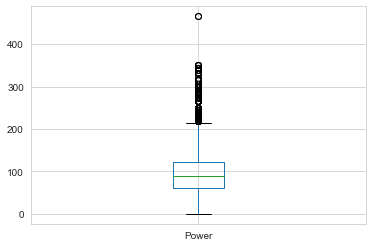

In [46]:
low_power_cars.boxplot(column='Power')

plt.show()

In [47]:
low_power_cars['Power'].describe()

count    39229.000000
mean        98.804902
std         41.636987
min          0.000000
25%         60.000000
50%         90.000000
75%        122.000000
max        465.500000
Name: Power, dtype: float64

У нас все равно остались записи с мощностью <1 л.с. Удалим их

In [48]:
low_power_cars = low_power_cars.query('Power > 1')

In [49]:
low_power_cars['Power'].describe()

count    38971.000000
mean        99.458995
std         40.988555
min          2.000000
25%         61.000000
50%         90.000000
75%        122.000000
max        465.500000
Name: Power, dtype: float64

In [50]:
df = pd.concat([df.query('Power>=50'),low_power_cars])

In [51]:
df.drop('Power_y',axis=1, inplace=True)

In [52]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  333592.000000     333592.000000  333592.000000  333592.000000   
mean     4497.118285       2003.442229     118.691364  128638.801290   
std      4522.726259         35.505913      51.304210   37105.291493   
min         0.000000       1000.000000       2.000000    5000.000000   
25%      1150.000000       1999.000000      75.000000  125000.000000   
50%      2800.000000       2003.000000     110.000000  150000.000000   
75%      6500.000000       2008.000000     144.000000  150000.000000   
max     20000.000000       9999.000000     585.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      333592.000000          333592.0  333592.000000  
mean            5.809603               0.0   50682.924719  
std             3.687669               0.0   25751.873582  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30419.000000  
50%             6.000000               0.0   49536.000000  
75%             9.000000               0.0   71229.000000  
max            12.000000               0.0   99998.000000

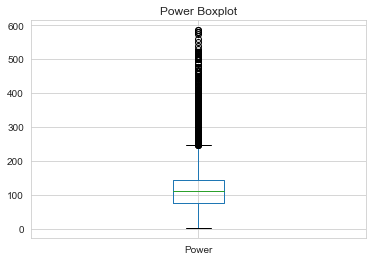

In [53]:
plt.title('Power Boxplot')
df.boxplot(column='Power')

plt.show()

Пробег

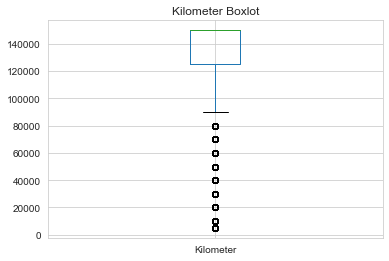

In [54]:
plt.title('Kilometer Boxlot')
df.boxplot(column='Kilometer')
plt.show()

Довольно странное распределение пробега, со средоточением объявлений в диапазоне 120-150 тыс. км. То есть в нашей выборке почти нет автомобилей с маленьким пробегом

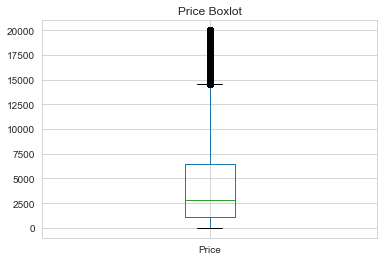

In [55]:
plt.title('Price Boxlot')
df.boxplot(column='Price', figsize=(15,15))
plt.show()

In [56]:
df.sort_values(by='Price')

Price  VehicleType  RegistrationYear Gearbox  Power  \
volvo_xc_reihe_10-20      0          NaN              2012     NaN  163.0   
bmw_3er_90-00             0  convertible              1997    auto  118.0   
bmw_3er_90-00             0          NaN              1995     NaN  118.0   
bmw_3er_90-00             0        sedan              1994    auto  118.0   
bmw_3er_90-00             0        sedan              1999  manual  118.0   
...                     ...          ...               ...     ...    ...   
217265                20000        coupe              2008    auto  224.0   
143875                20000        wagon              2011  manual  170.0   
9335                  20000        coupe              2009  manual  179.0   
190812                20000        wagon              2008    auto  232.0   
242890                20000        sedan              2004    auto  396.0   

                         Model  Kilometer  RegistrationMonth  FuelType  \
volvo_xc_reihe_10-20  xc_reihe      90000                  0       NaN   
bmw_3er_90-00              3er     150000                  3    petrol   
bmw_3er_90-00              3er     150000                  0       NaN   
bmw_3er_90-00              3er     150000                 12    petrol   
bmw_3er_90-00              3er     150000                  0    petrol   
...                        ...        ...                ...       ...   
217265                   other     150000                  6  gasoline   
143875                c_klasse      90000                  9  gasoline   
9335                        a5      80000                  5    petrol   
190812                      a6     150000                  4  gasoline   
242890                   other      90000                  7    petrol   

                              Brand NotRepaired          DateCreated  \
volvo_xc_reihe_10-20          volvo         NaN  2016-03-10 00:00:00   
bmw_3er_90-00                   bmw         yes  2016-03-26 00:00:00   
bmw_3er_90-00                   bmw         NaN  2016-03-11 00:00:00   
bmw_3er_90-00                   bmw          no  2016-03-18 00:00:00   
bmw_3er_90-00                   bmw         NaN  2016-03-31 00:00:00   
...                             ...         ...                  ...   
217265                mercedes_benz          no  2016-04-01 00:00:00   
143875                mercedes_benz          no  2016-03-25 00:00:00   
9335                           audi          no  2016-03-25 00:00:00   
190812                         audi          no  2016-03-26 00:00:00   
242890                       jaguar          no  2016-04-05 00:00:00   

                      NumberOfPictures  PostalCode             LastSeen  \
volvo_xc_reihe_10-20                 0       78727  2016-03-11 04:17:26   
bmw_3er_90-00                        0       25355  2016-03-31 09:45:27   
bmw_3er_90-00                        0       57520  2016-03-21 15:47:47   
bmw_3er_90-00                        0        3044  2016-03-18 15:38:55   
bmw_3er_90-00                        0       36179  2016-04-01 06:40:45   
...                                ...         ...                  ...   
217265                               0       10825  2016-04-05 13:15:40   
143875                               0       41517  2016-03-30 11:17:47   
9335                                 0       48167  2016-04-06 22:47:07   
190812                               0       93336  2016-04-06 11:45:22   
242890                               0       51467  2016-04-07 13:17:16   

                     Year_bin                   model_brand  
volvo_xc_reihe_10-20    10-20                           NaN  
bmw_3er_90-00           90-00                           NaN  
bmw_3er_90-00           90-00                           NaN  
bmw_3er_90-00           90-00                           NaN  
bmw_3er_90-00           90-00                           NaN  
...                       ...                           ...  
217265  

Уберем цену 0 и 1

In [57]:
df = df.query('Price > 1')

Рассмотрим года регистрации

In [58]:
np.sort(df['RegistrationYear'].unique())

array([1000, 1500, 1800, 1910, 1923, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1941, 1942, 1943, 1945, 1947,
       1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2900, 5000, 5911, 7000, 8200, 9999])

In [59]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

In [60]:
df['DateCreated'].dt.year.unique()

array([2016, 2015, 2014])

Все объявления были созданы в 2015 и 2016 году соответственно дата регистрации авто не может быть позже 2016 года, удалим эти записи

In [61]:
df = df.query('1910 <= RegistrationYear <= 2016')

Посмотрим распределение для годов регистрации нашей выборки

<AxesSubplot:>

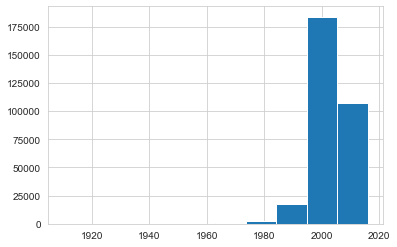

In [62]:
df['RegistrationYear'].hist()

In [63]:
df.describe()

Price  RegistrationYear          Power      Kilometer  \
count  312364.000000     312364.000000  312364.000000  312364.000000   
mean     4676.703119       2002.766087     119.250922  128490.062875   
std      4550.255794          6.551281      51.517125   36938.210688   
min         2.000000       1910.000000       5.000000    5000.000000   
25%      1250.000000       1999.000000      75.000000  125000.000000   
50%      2999.000000       2003.000000     110.000000  150000.000000   
75%      6790.000000       2007.000000     146.000000  150000.000000   
max     20000.000000       2016.000000     585.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      312364.000000          312364.0  312364.000000  
mean            5.897661               0.0   50922.022477  
std             3.645303               0.0   25740.274876  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30629.000000  
50%             6.000000               0.0   49757.000000  
75%             9.000000               0.0   71549.000000  
max            12.000000               0.0   99998.000000

С количественными признаками теперь порядок

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312364 entries, 2 to volvo_xc_reihe_10-20
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              312364 non-null  int64         
 1   VehicleType        296497 non-null  object        
 2   RegistrationYear   312364 non-null  int64         
 3   Gearbox            299782 non-null  object        
 4   Power              312364 non-null  float64       
 5   Model              312364 non-null  object        
 6   Kilometer          312364 non-null  int64         
 7   RegistrationMonth  312364 non-null  int64         
 8   FuelType           293521 non-null  object        
 9   Brand              312364 non-null  object        
 10  NotRepaired        259848 non-null  object        
 11  DateCreated        312364 non-null  datetime64[ns]
 12  NumberOfPictures   312364 non-null  int64         
 13  PostalCode         312364 non-null 

In [65]:
df['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Поставим заглушку на пропуски категориальных переменной NotRepaired

In [66]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

Обработаем пропуски по FuelType и VehicleType

In [67]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Создадим техническую базу моделей где будут указаны только тех. характеристики

In [68]:
tech_data=df[['Model','Brand','Power','FuelType','VehicleType']].copy()

In [69]:
tech_data = tech_data.dropna()

In [70]:
tech_data = tech_data.drop_duplicates(ignore_index=True)

In [71]:
tech_data

Model       Brand  Power  FuelType  VehicleType
0        grand        jeep  163.0  gasoline          suv
1         golf  volkswagen   75.0    petrol        small
2        fabia       skoda   69.0  gasoline        small
3          3er         bmw  102.0    petrol        sedan
4      2_reihe     peugeot  109.0    petrol  convertible
...        ...         ...    ...       ...          ...
21282    other       volvo  107.0    petrol        small
21283    other       volvo  131.0     other        wagon
21284    other       volvo  131.0  gasoline        wagon
21285      v70       volvo  163.0       lpg        wagon
21286      v70       volvo  163.0    petrol        wagon

[21287 rows x 5 columns]

Поставим заглушки на пропуски

In [72]:
df['FuelType'] = df['FuelType'].fillna('unknown')

In [73]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [74]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

Посмотрим значения и пропуски по полю FuelType

In [75]:
df.groupby(by='FuelType')['FuelType'].count()

FuelType
cng            509
electric        62
gasoline     92112
hybrid         197
lpg           4679
other          107
petrol      195855
unknown      18843
Name: FuelType, dtype: int64

Посмотрим значения и пропуски по полю VehicleType

In [76]:
df.groupby(by='VehicleType')['VehicleType'].count()

VehicleType
bus            27338
convertible    18970
coupe          14618
other           2608
sedan          85917
small          74646
suv            10919
unknown        15867
wagon          61481
Name: VehicleType, dtype: int64

Напишем функции которые по строке в выборке будут искать модель бренд, мощность  в нашей созданной базе тех характеристик авто и если найдутся такие то предлагать моду искомого значения

In [77]:
def fuel_fill(x):
    if x['FuelType'] == 'unknown':
        fuel_list=tech_data.loc[(tech_data['Model'] == x['Model']) &
                      (tech_data['Brand'] == x['Brand']) &
                      (tech_data['Power'] == x['Power'])
                      ]['FuelType'].mode()

        try:
            output = fuel_list[0]
        except:
            output = 'unknown'

        return  output
    else:
        return x['FuelType']


In [78]:
def vehicle_type_fill(x):
    if x['VehicleType'] == 'unknown':
        vh_type_list=tech_data.loc[(tech_data['Model'] == x['Model'])&
                                   (tech_data['Brand'] == x['Brand'])]['VehicleType'].mode()

        try:
            output = vh_type_list[0]
        except:
            output = 'unknown'

        return  output
    else:
        return x['VehicleType']

Применим наши функции

In [79]:
df['FuelType'] = df.apply(fuel_fill, axis=1)

In [80]:
df['VehicleType'] = df.apply(vehicle_type_fill, axis=1)

In [81]:
df.groupby(by='FuelType')['FuelType'].count()

FuelType
cng            537
electric        64
gasoline     97244
hybrid         198
lpg           5089
other          112
petrol      208768
unknown        352
Name: FuelType, dtype: int64

In [82]:
df.groupby(by='VehicleType')['FuelType'].count()

VehicleType
bus            29134
convertible    19055
coupe          14899
other           2683
sedan          91827
small          79226
suv            11400
wagon          64140
Name: FuelType, dtype: int64

Неплохо, большая часть пропусков заполнили

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312364 entries, 2 to volvo_xc_reihe_10-20
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              312364 non-null  int64         
 1   VehicleType        312364 non-null  object        
 2   RegistrationYear   312364 non-null  int64         
 3   Gearbox            312364 non-null  object        
 4   Power              312364 non-null  float64       
 5   Model              312364 non-null  object        
 6   Kilometer          312364 non-null  int64         
 7   RegistrationMonth  312364 non-null  int64         
 8   FuelType           312364 non-null  object        
 9   Brand              312364 non-null  object        
 10  NotRepaired        312364 non-null  object        
 11  DateCreated        312364 non-null  datetime64[ns]
 12  NumberOfPictures   312364 non-null  int64         
 13  PostalCode         312364 non-null 

Наша задача предсказать рыночную стоимость автомобиля, которая по логике не может сильно зависеть от даты размещения объявления (б/у авто не то чтобы сезонный товар), количества картинок в объявлении, почтового кода, месяца регистрации.

Уберем нецелевые признаки

In [84]:
df = df.drop(['DateCreated','NumberOfPictures','PostalCode','LastSeen','RegistrationMonth','model_brand'],axis=1)

In [85]:
df.head()

Price  VehicleType  RegistrationYear Gearbox  Power    Model  Kilometer  \
2   9800          suv              2004    auto  163.0    grand     125000   
3   1500        small              2001  manual   75.0     golf     150000   
4   3600        small              2008  manual   69.0    fabia      90000   
5    650        sedan              1995  manual  102.0      3er     150000   
6   2200  convertible              2004  manual  109.0  2_reihe     150000   

   FuelType       Brand NotRepaired Year_bin  
2  gasoline        jeep     unknown    00-10  
3    petrol  volkswagen          no    00-10  
4  gasoline       skoda          no    00-10  
5    petrol         bmw         yes    90-00  
6    petrol     peugeot          no    00-10

Разобьем очищенный датасет на train и test выборки в соотношении 8:2

In [86]:
df.reset_index(inplace=True)


In [87]:
df.drop(['index'],inplace=True, axis=1)

In [88]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'Year_bin'],
      dtype='object')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price',axis=1), df['Price'], test_size=0.20, random_state=12345)


In [90]:
X_train.shape

(249891, 10)

In [91]:
X_test.shape

(62473, 10)

In [92]:
y_train.shape

(249891,)

In [93]:
y_test.shape

(62473,)

Все в порядке

## Обучение моделей

Протестируем несколько моделей начиная от простой линейной регрессии

### 1 Линейная регрессия

In [94]:
columns = df.columns
columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'Year_bin'],
      dtype='object')

In [95]:
cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired','Year_bin']
num_col = ['RegistrationYear','Power','Kilometer']

Создадим преобразователь признаков, который будет применять масштабирование для численных признаков и OHE для категориальных, затем обучим его и применим к train и validate выборкам

In [96]:
transformer_for_linear = make_column_transformer(
                                                (StandardScaler(), num_col),
                                                (OneHotEncoder(
                                                               sparse=False,
                                                               handle_unknown='ignore',
                                                               ),
                                                 cat_col)
                                                )

In [97]:
X_train_transformed = transformer_for_linear.fit_transform(X_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [98]:
noise = np.random.normal(loc=.0, scale=1e-3, size=X_train_transformed.shape)

X_train_transformed = X_train_transformed + noise

In [99]:
linear_model = LinearRegression()
linear_model_l2 = Ridge()
linear_model_l1 = Lasso()
linear_model_l1_l2 = ElasticNet()

In [100]:
lg_cv_res = cross_validate(linear_model,
                           X_train_transformed,
                           y_train,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           return_estimator=True,
                           verbose=1
                           )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header,

In [101]:
lg_l2_res = cross_validate(linear_model_l2,
                           X_train_transformed,
                           y_train,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           return_estimator=True,
                           verbose=1
                           )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [102]:
lg_l1_res = cross_validate(linear_model_l1,
                           X_train_transformed,
                           y_train,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           return_estimator=True,
                           verbose=1
                           )


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.7s finished


In [103]:
lg_l12_res = cross_validate(linear_model_l1_l2,
                            X_train_transformed,
                            y_train,
                            scoring='neg_root_mean_squared_error',
                            n_jobs=-1,
                            return_estimator=True,
                            verbose=1
                            )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


In [104]:
(lg_cv_res['test_score'] * (-1)).mean()

2463.9670217916946

In [105]:
(lg_l2_res['test_score'] * (-1)).mean()

2463.80750162538

In [106]:
(lg_l1_res['test_score'] * (-1)).mean()

2492.4808716080947

In [107]:
(lg_l12_res['test_score'] * (-1)).mean()

3051.8530744731506

Результат на кросс-валидации получился ниже(лучше) целевого RMSE < 2500

### 2 Random Forest

Применим кодирование OrdinalEncoder для категориальных признаков

In [108]:
o_encode = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=777)

In [109]:
X_train_ord = X_train.copy()

In [110]:
X_train_ord[cat_col] = o_encode.fit_transform(X_train_ord[cat_col])

In [111]:
X_train_ord

VehicleType  RegistrationYear  Gearbox  Power  Model  Kilometer  \
223052          4.0              2003      1.0  116.0  103.0      80000   
34079           5.0              2008      1.0  120.0   80.0     150000   
72180           0.0              2013      1.0  105.0  116.0      60000   
275352          6.0              2010      1.0  122.0  218.0     100000   
170627          1.0              2005      1.0  131.0  149.0     150000   
...             ...               ...      ...    ...    ...        ...   
158838          6.0              2010      1.0  110.0  218.0      80000   
47873           4.0              1995      1.0   75.0  116.0     150000   
86398           4.0              1997      0.0  114.0   73.0     150000   
77285           5.0              1999      1.0   50.0  143.0     150000   
217570          4.0              1997      1.0   75.0  116.0     150000   

        FuelType  Brand  NotRepaired  Year_bin  
223052       6.0   10.0          0.0       0.0  
34079        6.0   21.0          0.0       0.0  
72180        6.0   37.0          0.0       1.0  
275352       6.0   37.0          0.0       0.0  
170627       2.0   27.0          0.0       0.0  
...          ...    ...          ...       ...  
158838       2.0   37.0          0.0       0.0  
47873        6.0   37.0          0.0       5.0  
86398        6.0   11.0          0.0       5.0  
77285        6.0   37.0          0.0       5.0  
217570       6.0   37.0          0.0       5.0  

[249891 rows x 10 columns]

In [112]:
rf_model = RandomForestRegressor(random_state=12345, n_jobs=-1)

Проверять модель будем на кросс-валидации с подбором параметров GridSearch

In [113]:
rf_param_grid = {'n_estimators':[200,400,600],
                 'max_depth':range(5,25,5)
                 }


In [114]:
from sklearn.model_selection import GridSearchCV

In [116]:
rf_grid = GridSearchCV(rf_model,
                        rf_param_grid,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        refit=True,
                        verbose=0)

In [117]:
rf_grid.fit(X_train_ord,y_train)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 25, 5),
                         'n_estimators': [200, 400, 600]},
             scoring='neg_root_mean_squared_error')

In [118]:
rf_grid.best_score_ * (-1)

1568.6059422972564

In [119]:
rf_grid.best_params_

{'max_depth': 20, 'n_estimators': 600}

Подобранные параметры делают модель RF довольно тяжелой и сложной - 600 деревьев довольно большой глубины

Довольно сложная модель получилась

### 3 CatBoost

In [121]:
cb_params = {
             'iterations':[500,1000],
             'depth': [3,5,6,8,10],
             'learning_rate': [0.01,0.1,0.5]
         }




In [122]:
cb_model = CatBoostRegressor(random_seed=12345,early_stopping_rounds=50,
                             loss_function='RMSE',cat_features=cat_col)

In [123]:
cb_grid = GridSearchCV(cb_model,
                       cb_params,
                        scoring='neg_root_mean_squared_error',
                        n_jobs=-1,
                        refit=True,
                        verbose=1)

In [124]:
cb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

0:	learn: 4526.4768398	total: 252ms	remaining: 2m 5s
1:	learn: 4501.8127984	total: 324ms	remaining: 1m 20s
2:	learn: 4477.6467448	total: 463ms	remaining: 1m 16s
3:	learn: 4453.8017736	total: 574ms	remaining: 1m 11s
4:	learn: 4430.2831046	total: 813ms	remaining: 1m 20s
5:	learn: 4406.6200147	total: 1.08s	remaining: 1m 29s
6:	learn: 4383.4493924	total: 1.31s	remaining: 1m 32s
7:	learn: 4360.3928717	total: 1.46s	remaining: 1m 29s
8:	learn: 4338.0280763	total: 1.6s	remaining: 1m 27s
9:	learn: 4315.5940503	total: 1.79s	remaining: 1m 27s
10:	learn: 4293.8680505	total: 1.92s	remaining: 1m 25s
11:	learn: 4272.3465942	total: 2.14s	remaining: 1m 27s
12:	learn: 4250.9051246	total: 2.36s	remaining: 1m 28s
13:	learn: 4229.9120582	total: 2.5s	remaining: 1m 26s
14:	learn: 4209.2279711	total: 2.65s	remaining: 1m 25s
15:	learn: 4188.6448640	total: 2.7s	remaining: 1m 21s
16:	learn: 4168.2242265	total: 2.82s	remaining: 1m 20s
17:	learn: 4147.8781883	total: 2.97s	remaining: 1m 19s
18:	learn: 4128.0074769	

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x2929b6670>,
             n_jobs=-1,
             param_grid={'depth': [3, 5, 6, 8, 10], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1, 0.5]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [125]:
cb_grid.best_score_ * (-1)

1524.3946718553445

Результат модели на кросс-валидации незначительно лучше, чем у модели Random Forest

In [126]:
cb_grid.best_params_

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.1}

In [135]:
cb_b_model = cb_grid.best_estimator_

In [136]:
for f_n, f_i in sorted(zip(cb_b_model_2.feature_names_,
                           cb_b_model_2.feature_importances_),
                       key=lambda x: x[1],
                       reverse=True):
    print(f'{f_n}: {f_i:.2f}')


RegistrationYear: 20.43
Power: 17.93
Brand: 16.35
Kilometer: 10.78
VehicleType: 9.10
Year_bin: 8.06
Model: 5.29
NotRepaired: 4.39
FuelType: 3.96
Gearbox: 3.71
RegistrationYear: 20.43
Power: 17.93
Brand: 16.35
Kilometer: 10.78
VehicleType: 9.10
Year_bin: 8.06
Model: 5.29
NotRepaired: 4.39
FuelType: 3.96
Gearbox: 3.71


Выглядит логично - наиболее важными признаками являются год регистрация(косвенно = возраст автомобиля), мощность и бренд

## Анализ моделей

Сравним время обучения и предсказаний для моделей  RandomForestRegressor и CatBoostRegressor

### Random Forest

In [151]:
from sklearn.pipeline import Pipeline

In [152]:
rf_pipe = Pipeline([('cat_enc', o_encode),
                    ('regressor', rf_model)])

In [153]:
start = time.perf_counter()

rf_pipe = rf_pipe.fit(X_train, y_train)

end = time.perf_counter()

In [154]:
elapsed_time = end - start
print(f'Время обучения модели = {elapsed_time}')


Время работы программы = 29.062025082996115


In [164]:
start = time.perf_counter()

y_pred = rf_pipe.predict(X_train)

end = time.perf_counter()

In [165]:
elapsed_time = end - start
print(f'Время вычисления предсказаний = {elapsed_time}')

Время вычисления предсказаний = 5.761601291000261


### CatBoost

In [158]:
start = time.perf_counter()

cb_b_model.fit(X_train, y_train)

end = time.perf_counter()

0:	learn: 4217.5210605	total: 136ms	remaining: 2m 15s
1:	learn: 3925.1340627	total: 213ms	remaining: 1m 46s
2:	learn: 3662.5362532	total: 279ms	remaining: 1m 32s
3:	learn: 3429.9748349	total: 394ms	remaining: 1m 38s
4:	learn: 3224.2709881	total: 472ms	remaining: 1m 33s
5:	learn: 3045.1044057	total: 545ms	remaining: 1m 30s
6:	learn: 2886.2576019	total: 620ms	remaining: 1m 27s
7:	learn: 2748.5470256	total: 687ms	remaining: 1m 25s
8:	learn: 2627.9575847	total: 760ms	remaining: 1m 23s
9:	learn: 2521.9764899	total: 827ms	remaining: 1m 21s
10:	learn: 2426.8840965	total: 891ms	remaining: 1m 20s
11:	learn: 2346.2278539	total: 1.02s	remaining: 1m 23s
12:	learn: 2273.7246094	total: 1.11s	remaining: 1m 24s
13:	learn: 2212.4073788	total: 1.18s	remaining: 1m 22s
14:	learn: 2157.6404062	total: 1.24s	remaining: 1m 21s
15:	learn: 2111.4997093	total: 1.3s	remaining: 1m 20s
16:	learn: 2071.8873378	total: 1.38s	remaining: 1m 20s
17:	learn: 2036.5861969	total: 1.46s	remaining: 1m 19s
18:	learn: 2001.52364

In [159]:
elapsed_time = end - start
print(f'Время обучения модели = {elapsed_time}')


Время обучения модели = 83.28713974999846


In [166]:
start = time.perf_counter()

y_pred = cb_b_model.predict(X_train)

end = time.perf_counter()

In [167]:
elapsed_time = end - start
print(f'Время вычисления предсказаний = {elapsed_time}')

Время вычисления предсказаний = 0.569951666999259


Вывод: модель CatBoost незначительно дольше обучается, но превосходит случайный лес по скорости предсказаний (для оценки скорости работы случайного леса был включен также шаг на кодирование категориальных признаков с помощью OrdinalEncoder)

## Тестирование модели

Формально, лучше всего показала себя модель на базе градиентного бустинга, (хотя Random Forest показал весьма схожий результат на кросс-валидации) протестируем ее на тестовой выборке

In [169]:
y_p = cb_b_model.predict(X_test)
rmse = mean_squared_error(y_test, y_p, squared=False)
print('RMSE модели RandomForest на тестовой выборке:', rmse)

RMSE модели RandomForest на тестовой выборке: 1527.6264205265113


Выбранная модель показывает целевой результат по метрике RMSE < 2500. При этом ее точность на тестовой выборке почти такая же как и на кросс-валидации.